In [1]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## An exercise in quantile mapping:

“Quantile mapping bias correction algorithms are commonly used to correct systematic distributional biases in precipitation outputs from climate models” (Cannon+2015)

Essentially, climate models are compared to historical observations over some medium- to long-term timescales (decades) so that the model projections can be corrected for any systematic bias. There are several ways to do bias corrections but a class of techniques generally called quantile mapping aim to preserve the characteristics of the observed trends (for, e.g., temps, this can mean the mean as well as the extreme values at the tails of the distribution) as well as include the long term trends in the climate models (these techniques are typically called quantile delta mapping).

Below I'll attempt to explore how these algorithms work.


## Quantile Delta Mapping

“[...] Quantile delta mapping (QDM), explicitly preserves relative changes in simulated precipitation quantiles from a climate model. Systematic distributional biases relative to observations in a historical baseline period are corrected by first detrending all projected future quantiles from a model and then applying quantile mapping to the detrended series. After detrending and quantile mapping, projected trends in the modeled quantiles are reintroduced on top of the bias-corrected outputs, thus ensuring that the climate sensitivity of the underlying climate model, at least so far as quantiles are concerned, is unaffected by the bias correction.” (Cannon+2015)

![qdm](https://journals.ametsoc.org/view/journals/clim/28/17/full-jcli-d-14-00754.1-f1.jpg)

First, for the projected model data, the outputs are detrended by their quantile (basically removing the effect of the climate model). This is done by finding the quantile of the projected output at some time and the same quantile in the historic model data (Eq. 3 in Cannon+2015) and then finding the relative change in the value (== delta quantile, Eq 4). Then the projected model quantile can be bias corrected from the observed values over the historical period (Eq. 5) which can then be applied to bias correct the projected value (Eq. 6).

## Exercise with Synthetic Data: Quantile Mapping

Following Cannon+15 (which itself follows Maurer & Pierce 2014), we assume the synthetic observations of precipitation and the climate model outputs both follow a gamma distribution,, 

In [2]:
mu = 30
std = 15
scale=7.5
synthetic_obs_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 30
std = 10.5
scale=3.68
historical_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 42
std = 10.5
scale=2.63
projected_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
draws = np.linspace(0,100,10000)

obs_rvs = synthetic_obs_dist.rvs(len(draws))
hm_rvs = historical_model_dist.rvs(len(draws))
pm_rvs = projected_model_dist.rvs(len(draws))

obs_pdf = synthetic_obs_dist.pdf(draws)
hm_pdf = historical_model_dist.pdf(draws)
pm_pdf = projected_model_dist.pdf(draws)

obs_cdf = synthetic_obs_dist.cdf(draws)
hm_cdf = historical_model_dist.cdf(draws)
pm_cdf = projected_model_dist.cdf(draws)

In [3]:
print(synthetic_obs_dist.mean(),
historical_model_dist.mean(),
projected_model_dist.mean())

30.0 30.000000000000004 42.0


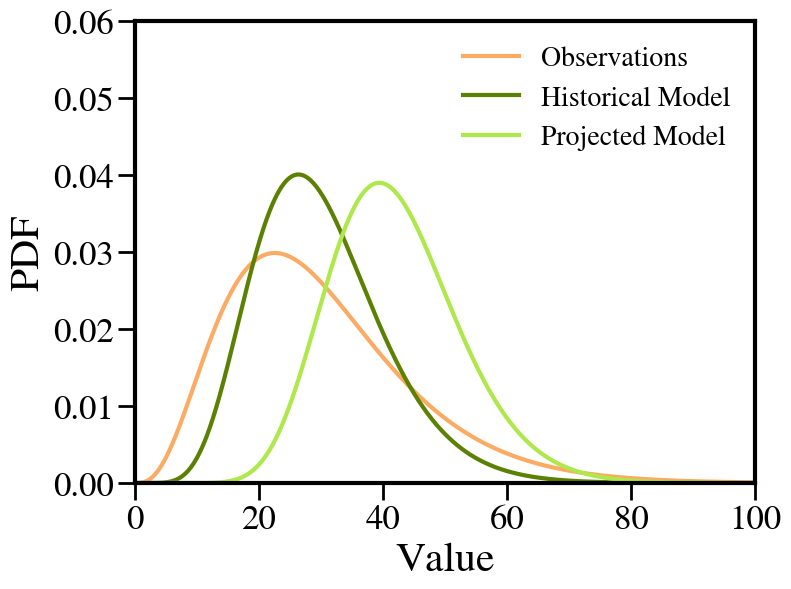

In [4]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.06])
plt.xlim([0,100])
plt.legend(frameon=False)

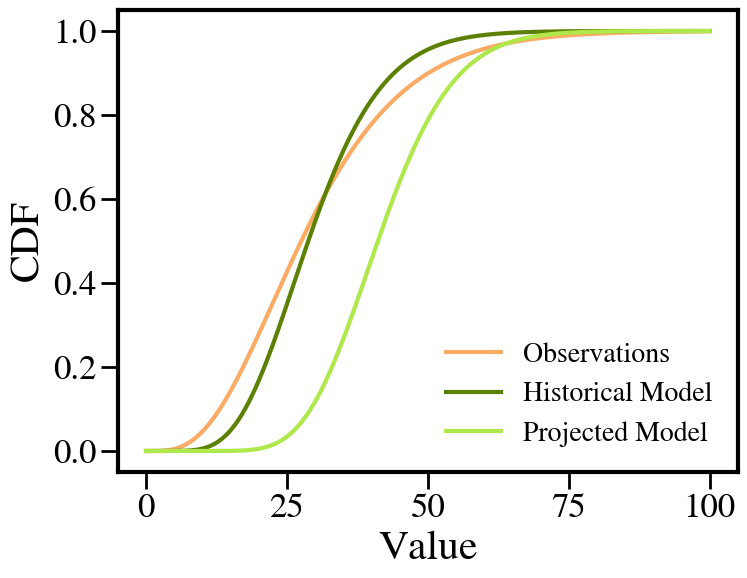

In [5]:
plt.plot(draws,obs_cdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_cdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_cdf,color='#AEE84A', lw=3, label='Projected Model')
#plt.plot(draws,projected_model_dist.cdf(synthetic_obs_dist.ppf(hm_cdf)))
plt.ylabel('CDF')
plt.xlabel('Value')
plt.legend(frameon=False)

In this example, the observed and modeled data for the historical period have the same mean, but the GCM underestimates the observed standard deviation by 30%; the model projects a 40% increase in the mean for the future period, with no accompanying change in the standard deviation.

In [25]:
#define some time periods and gather data points
historical_time = np.arange(1971,2000,0.1)
projected_time = np.arange(2041, 2070, 0.05)

observations = synthetic_obs_dist.rvs(len(historical_time))
hist_model = historical_model_dist.rvs(len(historical_time))
proj_model = projected_model_dist.rvs(len(projected_time))

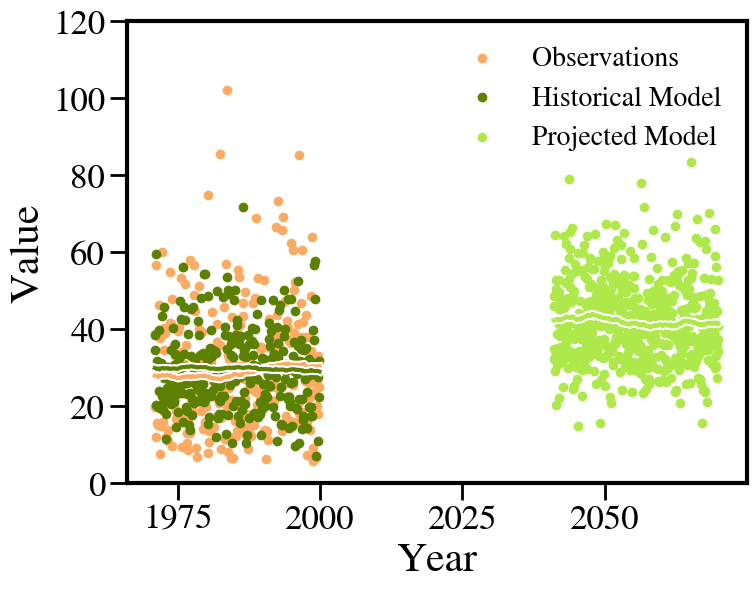

In [45]:
plt.scatter(historical_time, observations, color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,color='#AEE84A', label='Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A', lw=3)


plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False)

If CDFs and inverse CDFs (i.e., quantile functions) are estimated empirically from the data, the algorithm can be illustrated with the aid of a quantile–quantile plot, which is the scatterplot between empirical quantiles of observed and modeled data (i.e., the sorted values in each sample when the number of observed and modeled samples are the same). In this case, QM amounts to a lookup table whose entries are found by interpolating between points in the quantile–quantile plot of the historical data. The transfer function is constructed using information from the historical period exclusively;

In [8]:

percentile = scipy.stats.percentileofscore(hist_model, proj_model)
corrected_proj_model_qm = np.percentile(observations, percentile)


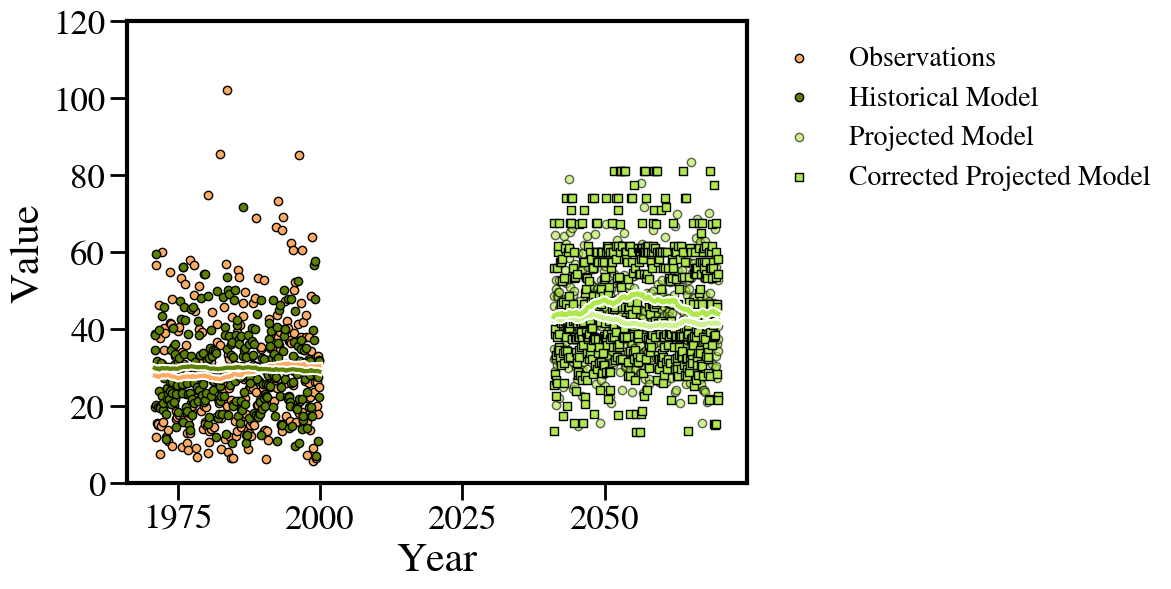

In [46]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, corrected_proj_model_qm, edgecolor='black',color='#AEE84A', marker='s', label='Corrected Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
corr_proj_mean = np.convolve(corrected_proj_model_qm, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A',alpha=0.6, lw=3)

plt.plot(ptime, corr_proj_mean, color='white', lw=6)
plt.plot(ptime, corr_proj_mean, color='#AEE84A', lw=3)

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [47]:
np.mean(corrected_proj_model_qm), np.mean(proj_model), np.mean(observations)

(45.450040733708086, 41.838161824948585, 29.074373163346888)

In [48]:
np.std(corrected_proj_model_qm), np.std(proj_model)

(14.616618606958342, 10.410622446375703)

However, while the skew of the projected model aligns more with the historical data, the projected increase in the mean is no longer just ~40% but now at ~60%: As demonstrated by Maurer and Pierce (2014), underestimation of variance for a bounded, right-skewed variable will result in an amplification of projected trends in the mean by QM (and vice versa for overestimation of variance)

In [12]:
#now for the PDF from the actual distributions
corr_pm_rvs_qm = synthetic_obs_dist.ppf(historical_model_dist.cdf(sorted(pm_rvs)))
corr_pm_kde = scipy.stats.gaussian_kde(corr_pm_rvs_qm)
corr_pm_pdf = corr_pm_kde(draws)

#corrected_proj_model_qm_pdf =scipy.stats.gaussian_kde(corrected_proj_model_qm_rvs)(draws)

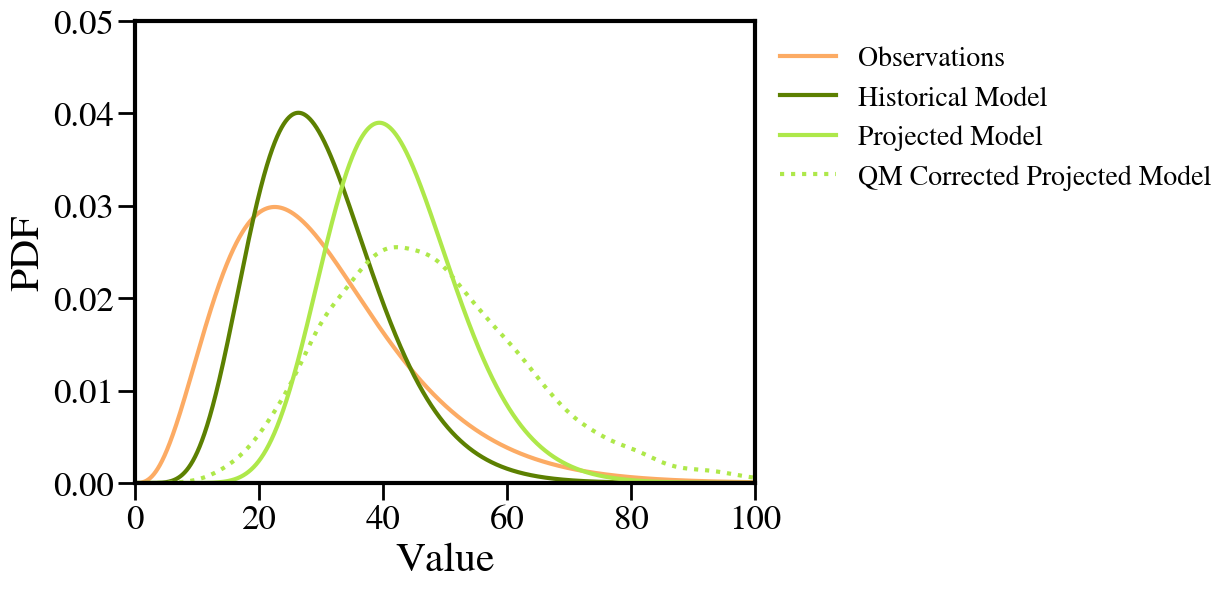

In [13]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corr_pm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.xlim([0,100])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [14]:
print(projected_model_dist.mean(), np.mean(corr_pm_rvs_qm))

42.0 47.615424665980576


In [15]:
print(projected_model_dist.std(), np.std(corr_pm_rvs_qm))

10.509995242624994 16.37267299048041


Owing to the amplification of projected trends in the mean by QM, we can instead apply the detrended quantile mapping technique, which enables us to avoid extrapolating for values that lie outside of the historical data (like for the projected increase in the mean by 40%).

## Exercise with Synthetic Data: Detrended Quantile Mapping

In [16]:
#detrended quantile mapping

projected_mean = np.mean(proj_model)
historical_mean = np.mean(hist_model)

percentile = scipy.stats.percentileofscore(hist_model, (historical_mean/projected_mean)*proj_model)
corrected_proj_model_dqm = np.percentile(observations, percentile) * (projected_mean/historical_mean)


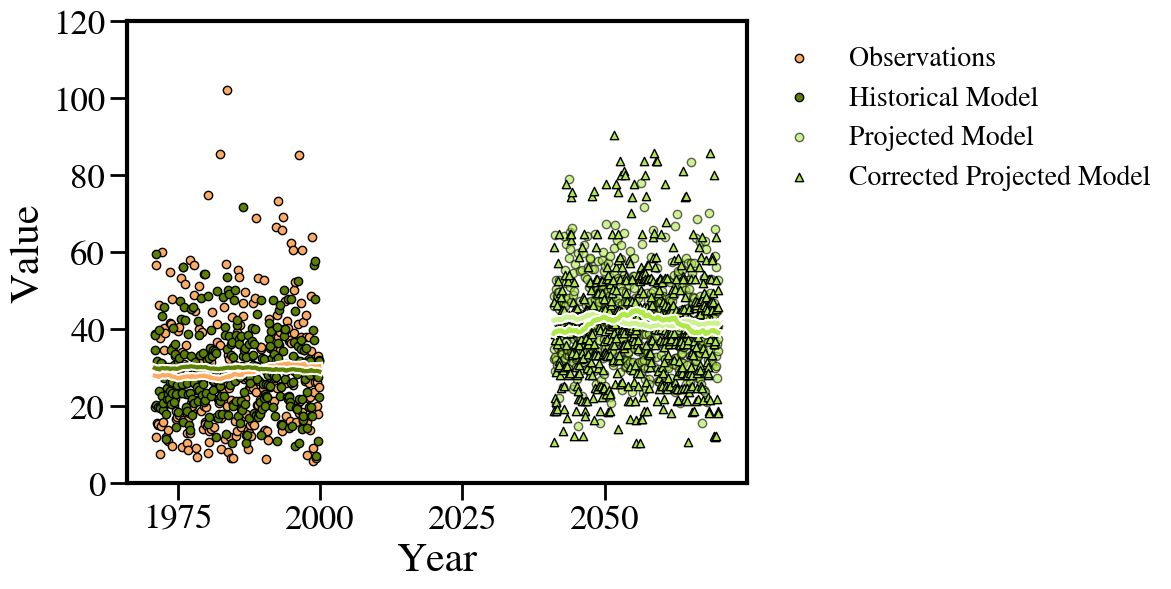

In [49]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, corrected_proj_model_dqm, edgecolor='black',color='#AEE84A', marker='^', label='Corrected Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
corr_proj_mean = np.convolve(corrected_proj_model_dqm, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A',alpha=0.6, lw=3)

plt.plot(ptime, corr_proj_mean, color='white', lw=6)
plt.plot(ptime, corr_proj_mean, color='#AEE84A', lw=3)

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [50]:
np.mean(corrected_proj_model_dqm), np.mean(proj_model), np.mean(observations)

(40.838775308720905, 41.838161824948585, 29.074373163346888)

In [51]:
np.std(corrected_proj_model_dqm), np.std(proj_model)

(14.590200466758596, 10.410622446375703)

In [20]:
detrended_rvs = np.array(sorted(pm_rvs))*(historical_mean/projected_mean)

corr_pm_rvs_dqm = synthetic_obs_dist.ppf(historical_model_dist.cdf(detrended_rvs))*(projected_mean/historical_mean)
corr_pm_kde_dqm = scipy.stats.gaussian_kde(corr_pm_rvs_dqm)
corr_pm_pdf_dqm = corr_pm_kde_dqm(draws)

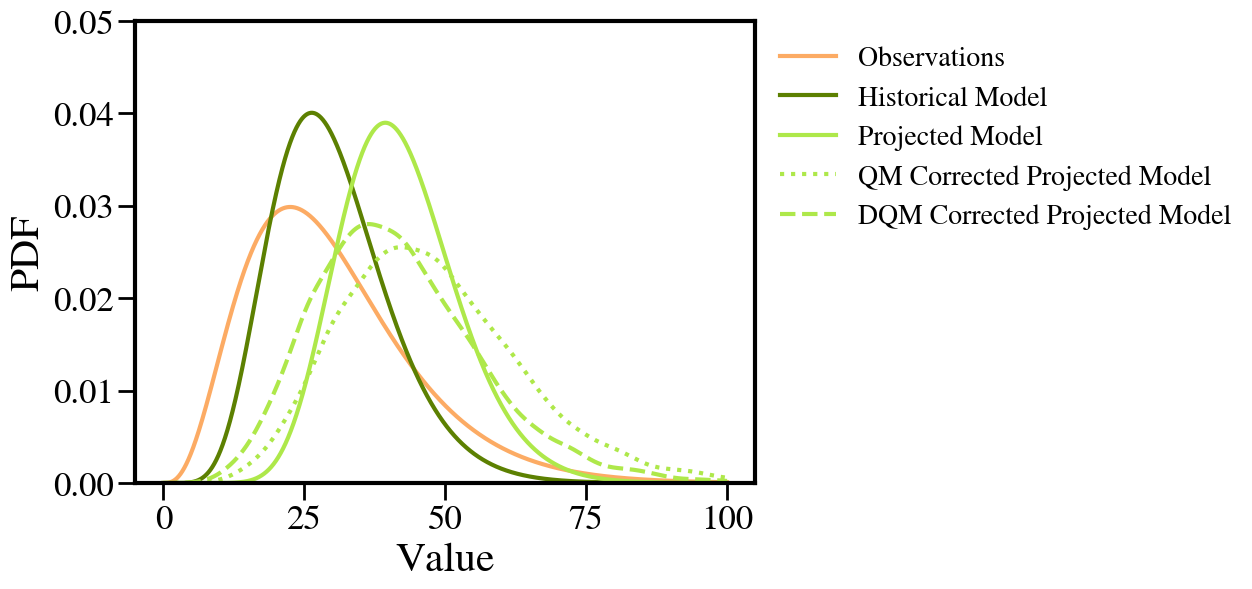

In [52]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corr_pm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.plot(draws, corr_pm_pdf_dqm, color='#AEE84A', lw=3, ls='--', label='DQM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [22]:
print(projected_model_dist.mean(), np.mean(corr_pm_rvs_dqm))

42.0 41.68934279245367


In [53]:
print(projected_model_dist.std(),np.std(corr_pm_rvs_dqm), synthetic_obs_dist.std())

10.509995242624994 15.028265651052854 15.0


## Exercise with Real Data: Quantile Mapping Gridded Data

In the blend, quantile mapping is done at every grid point for every model for every forecast lead time. The observations are compiled over a timescale of 60 days to construct the CDFs while the model CDFs are (for the ensemble models) constructed from all members. 

We'll do a watered down version here: we'll load in 50 days of URMA data (our observations) and construct the CDF of temperature at lead time = 0 for one grid point. We'll then load in the ensemble members for GEFS and construct the model CDF and then quantile map between the two.

** A Note **
Not only is this a very watered down example but the URMA and GEFS data are from two different periods. I know, I know, this doesn't make any sense but it'll just be for illustrative purposes.

In [61]:
urma_dir='/scratch2/STI/mdl-sti/Eric.Engle/urma_climo/urma/'
first_day=datetime.date(2020,1,29)   
urma_path = urma_dir+f'urma2p5.{first_day.strftime("%Y%m%d")}/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp.grib2io'


filters = dict(productDefinitionTemplateNumber=0, typeOfFirstFixedSurface=103,shortName='TMP')
u1 = xr.open_dataset(urma_path,engine='grib2io', filters=filters)

In [57]:
adam_dat_dir = '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/'
gefs_paths = sorted(glob(adam_dat_dir+'gep*.t12z.pgrb2ab.0p50'))
filters = dict(productDefinitionTemplateNumber=1, typeOfFirstFixedSurface=1,shortName='TMP',leadTime=urma_data.leadTime.data)
g1 = xr.open_mfdataset(gefs_paths[0],engine='grib2io', filters=filters)

Let's first get a feel for the data - first time working with URMA!!

Text(0.5, 1.0, 'GEFS Member 1')

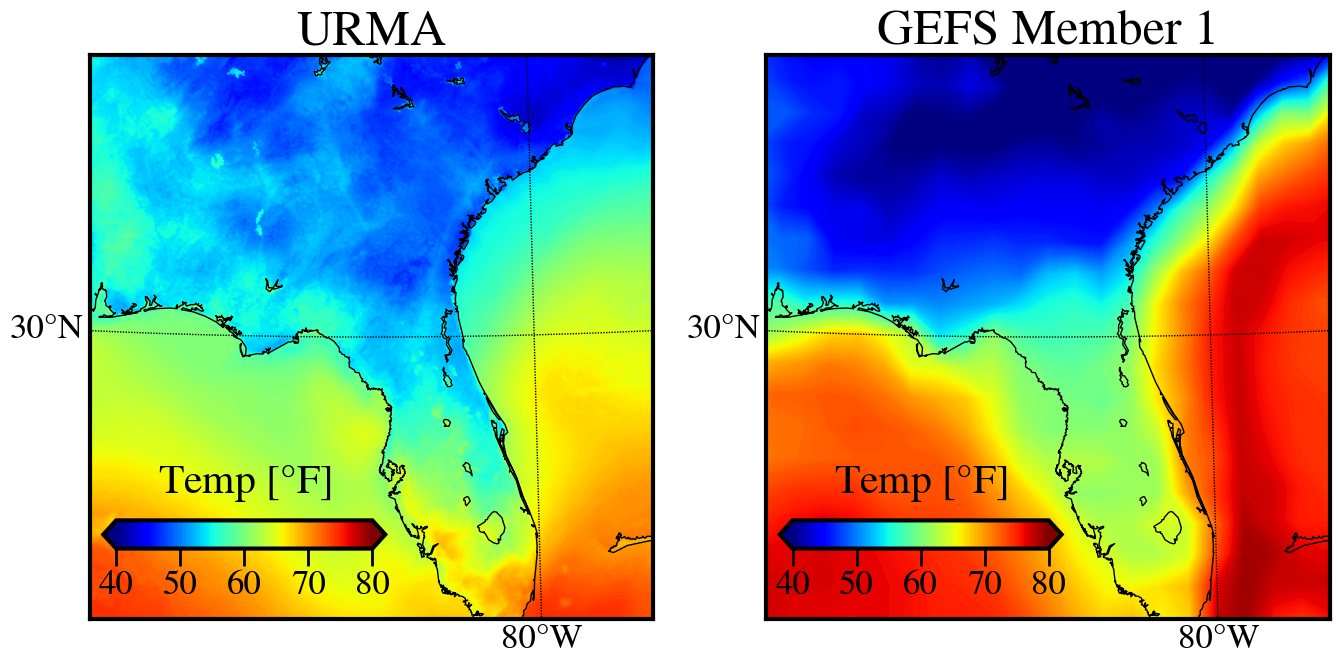

In [62]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

temp_range = np.linspace(40,80,200)

#original grid
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
u_tmp = u1.TMP.data * units(u1.TMP.units)
cs = m.contourf(xx,yy,u_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = g1.latitude.data, g1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_tmp = g1.TMP.data * units(g1.TMP.units)
cs = m.contourf(xx,yy,gefs_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA')
axes[1].set_title('GEFS Member 1')

So the GEFS members are on a (iirc) 1 degree grid, which is about 100 km. The URMA data is at much finer spatial resolution = 2.5 km! So let's interpolate GEFS onto the URMA grid.

In [63]:
#the xarray backend can make use of grib2io's interp functions to interpolate the data onto a different grid
grid_def_out = u1.grib2io.griddef()
gefs_to_urma = g1.TMP.grib2io.interp('bilinear', grid_def_out)

Text(0.5, 1.0, 'GEFS Member 1')

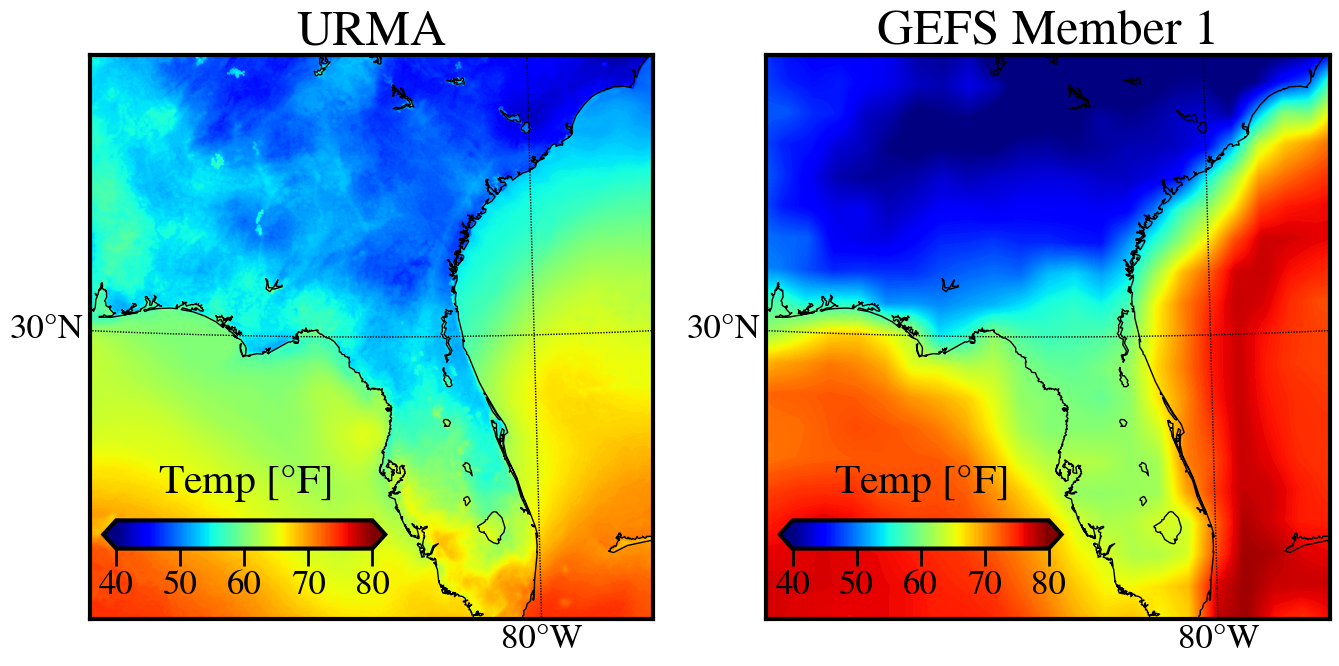

In [64]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

temp_range = np.linspace(40,80,200)

#original grid
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
u_tmp = u1.TMP.data * units(u1.TMP.units)
cs = m.contourf(xx,yy,u_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = gefs_to_urma.latitude.data, gefs_to_urma.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_tmp = gefs_to_urma.data * units(g1.TMP.units)
cs = m.contourf(xx,yy,gefs_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA')
axes[1].set_title('GEFS Member 1')

In [66]:
np.shape(gefs_to_urma.data), np.shape(u1.TMP.data)

((1597, 2345), (1597, 2345))

Ok. Now we can turn to the QM exercise. 

In [2]:

#gather the previous 10 days of observation from  our 
urma_dir='/scratch2/STI/mdl-sti/Eric.Engle/urma_climo/urma/'
urma_paths = []
for days_ago in range(50):
    first_day=datetime.date(2020,1,29)   
    this_day = first_day - datetime.timedelta(days=days_ago)
    urma_paths.append(urma_dir+f'urma2p5.{this_day.strftime("%Y%m%d")}/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp.grib2io')


filters = dict(productDefinitionTemplateNumber=0, typeOfFirstFixedSurface=103,shortName='TMP')
urma_data = xr.open_mfdataset(urma_paths, chunks=None,engine='grib2io', filters=filters, parallel=False, concat_dim=[
        pd.Index(np.arange(len(urma_paths)), name="obs_day"),
    ],
    combine="nested",)

In [75]:
urma_data.TMP

<xarray.DataArray 'TMP' (obs_day: 10, y: 1597, x: 2345)>
dask.array<concatenate, shape=(10, 1597, 2345), dtype=float32, chunksize=(1, 1597, 2345), chunktype=numpy.ndarray>
Coordinates:
    refDate                   (obs_day) datetime64[ns] 2020-01-29 ... 2020-01-20
    leadTime                  timedelta64[ns] 00:00:00
    valueOfFirstFixedSurface  float64 2.0
    latitude                  (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude                 (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    validDate                 (obs_day) datetime64[ns] 2020-01-29 ... 2020-01-20
  * obs_day                   (obs_day) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: y, x
Attributes:
    GRIB2IO_section0:  [1196575042          0          0          2    3652869]
    GRIB2IO_section1:  [   7    4    1    1    0 2020    1   29    0    0    ...
    GRIB2IO_section3:  [        0   3744965         0         0        30    ...
    GRIB2IO_section4:  [  0   0   0   0   0   0 118   0   0   1   0 103   0  ...
    fullName:          Temperature
    shortName:         TMP
    units:             K

In [65]:
#get temperatures at tallahassee airport
urma_to_stat = urma_data.grib2io.interp_to_stations('bilinear', ['KTLH'], [30.4382], [-84.2806])
urma_tall_temp = np.ravel(urma_to_stat.TMP.data.compute()) * units(urma_data.TMP.units)

In [5]:
import dask
dask.config.set(scheduler='processes', num_workers=16)

In [3]:
#get GEFS members

adam_dat_dir = '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/'
gefs_paths = sorted(glob(adam_dat_dir+'gep*.t12z.pgrb2ab.0p50'))
gefs_path = gefs_paths
print(gefs_path)
filters = dict(productDefinitionTemplateNumber=1, typeOfFirstFixedSurface=1,leadTime=urma_data.leadTime.data)
gefs_data = xr.open_mfdataset(gefs_path, chunks=None,engine='grib2io', filters=filters, parallel=True, concat_dim=[pd.Index(np.arange(len(gefs_path)), name="member")],combine="nested")



['/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep01.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep02.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep03.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep04.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep05.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep06.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep07.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep08.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep09.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/gep10.t12z.pgrb2ab.0p50', '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/

In [8]:
gefs_data.TMP

<xarray.DataArray 'TMP' (member: 30, y: 361, x: 720)>
dask.array<concatenate, shape=(30, 361, 720), dtype=float32, chunksize=(1, 361, 720), chunktype=numpy.ndarray>
Coordinates:
    refDate                   datetime64[ns] 2023-01-29T12:00:00
    leadTime                  timedelta64[ns] 00:00:00
    valueOfFirstFixedSurface  float64 0.0
    perturbationNumber        (member) int64 1 2 3 4 5 6 7 ... 25 26 27 28 29 30
    latitude                  (y, x) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    longitude                 (y, x) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    validDate                 datetime64[ns] 2023-01-29T12:00:00
  * member                    (member) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Dimensions without coordinates: y, x
Attributes:
    GRIB2IO_section0:  [1196575042          0          0          2     167408]
    GRIB2IO_section1:  [   7    2    2    1    1 2023    1   29   12    0    ...
    GRIB2IO_section3:  [        0    259920         0         0         0    ...
    GRIB2IO_section4:  [  0   1   0   0   4   0 107   0   0   1   0   1   0  ...
    fullName:          Temperature
    shortName:         TMP
    units:             K

In [66]:
#get temperature forecasts at tallahassee airport
gefs_to_stat = gefs_data.grib2io.interp_to_stations('bilinear', ['KTLH'], [30.4382], [-84.2806])
gefs_tall_temp = np.ravel(gefs_to_stat.TMP.data.compute()) * units(gefs_data.TMP.units)

In [67]:
gefs_tall_temp.to(units.fahrenheit)

Magnitude,[52.510250091552734 51.83684539794922 52.23960494995117 52.31068420410156 52.59874725341797 52.450321197509766 51.91341781616211 52.30233383178711 51.46171569824219 52.406375885009766 52.25773239135742 52.46043014526367 52.38231658935547 52.61703872680664 52.18269348144531 52.3695182800293 52.28569030761719 51.94286346435547 52.303653717041016 52.054317474365234 53.155643463134766 52.2893180847168 51.797569274902344 52.28838348388672 52.073543548583984 52.40220260620117 52.66587448120117 52.152645111083984 52.30903625488281 52.27640914916992]
Units,degree_Fahrenheit


In [68]:
urma_tall_temp.to(units.fahrenheit)

Magnitude,[57.21855163574219 56.86781311035156 54.102718353271484 52.12089538574219 64.0191421508789 62.268306732177734 52.142208099365234 41.21317672729492 43.663455963134766 50.12594223022461 65.21917724609375 61.88955307006836 70.2231216430664 70.9185562133789 70.99530029296875 69.79712677001953 68.31963348388672 71.2140884399414 71.28132629394531 61.92207336425781 52.93437957763672 56.52581024169922 56.81584930419922 50.220645904541016 59.138465881347656 74.10338592529297 66.37428283691406 55.11258316040039 52.31541061401367 56.23483657836914 69.55839538574219 70.1637954711914 70.63687133789062 68.2838134765625 63.52596664428711 63.87676239013672 54.81699752807617 63.81688690185547 58.81063461303711 58.21737289428711 46.94968795776367 44.50423812866211 53.78889465332031 66.54412841796875 59.27513885498047 54.641597747802734 53.75566101074219 56.77871322631836 49.0033073425293 69.81427001953125]
Units,degree_Fahrenheit


In [34]:
urma_cdf=ECDF(urma_tall_temp.to(units.fahrenheit))

In [46]:
gefs_cdf = ECDF(gefs_tall_temp.to(units.fahrenheit))

Text(0.5, 1.0, 'KTLH 2023-01-29T12:00:00.000000000')

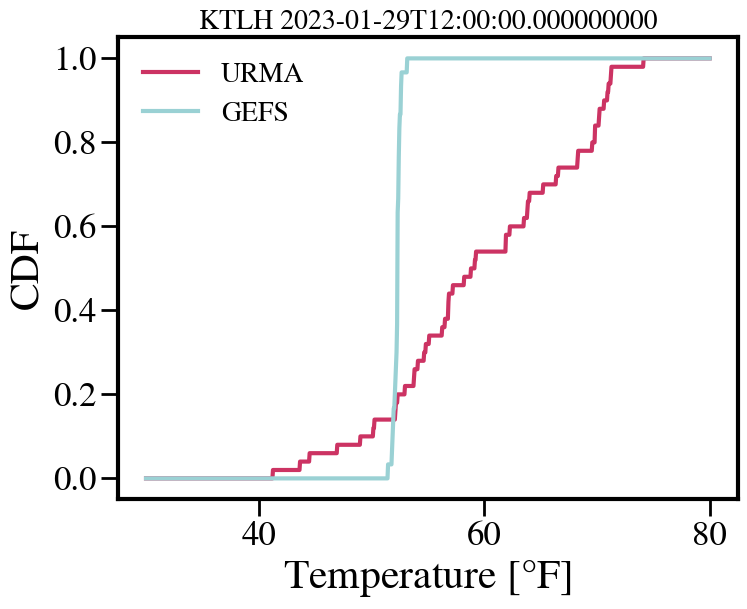

In [67]:
x=np.linspace(30,80,1000)

plt.plot(x, urma_cdf(x), color='#CC3363', lw=3,label='URMA')
plt.plot(x, gefs_cdf(x), color='#9AD1D4', lw=3,label='GEFS')
plt.xlabel('Temperature [$\degree$F]')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.title(f'KTLH {gefs_data.refDate.data}', fontsize=20)

As stated before, the GEFS data and URMA are not from the same time period. So we shouldn't expect much relation (maybe) between the forecast and analysis CDFs. But at least for demonstration purposes we can now do the QM calculations.

Also IRL, I believe the QM would involve 60 days of previous GEFS forecasts to which the GEFS forecast in question would be mapped to (as above with the historical/project model example above). Alas, I don't have this data so we'll just QM the GEFS forecast to the observations.

In [84]:
percentile = scipy.stats.percentileofscore(gefs_tall_temp.to(units.fahrenheit).magnitude, gefs_tall_temp.to(units.fahrenheit).magnitude)
corrected_gefs_qm = np.percentile(urma_tall_temp.to(units.fahrenheit).magnitude, percentile)

In [70]:
corrected_gefs_cdf = ECDF(corrected_gefs_qm)

Text(0.5, 1.0, 'KTLH 2023-01-29T12:00:00.000000000')

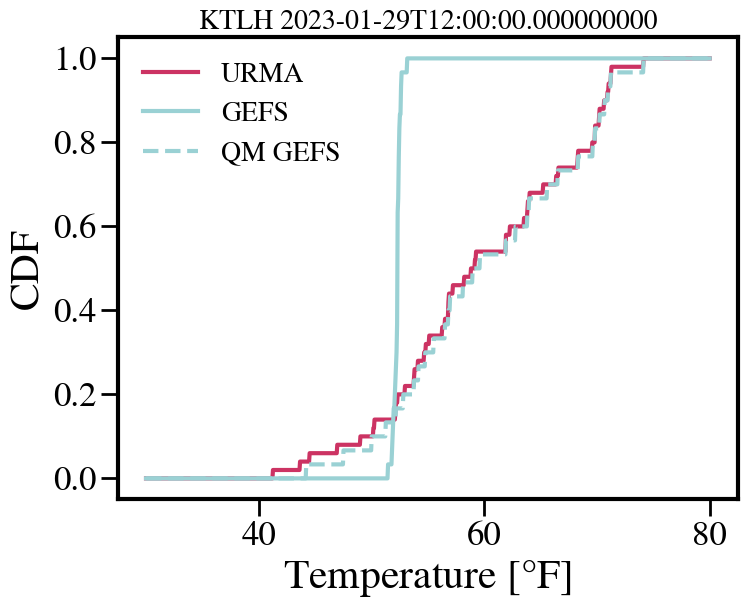

In [72]:
x=np.linspace(30,80,1000)

plt.plot(x, urma_cdf(x), color='#CC3363', lw=3,label='URMA')
plt.plot(x, gefs_cdf(x), color='#9AD1D4', lw=3,label='GEFS')
plt.plot(x, corrected_gefs_cdf(x),color='#9AD1D4',ls='--', lw=3,label='QM GEFS' )
plt.xlabel('Temperature [$\degree$F]')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.title(f'KTLH {gefs_data.refDate.data}', fontsize=20)

## Exercise with Real Data: Quantile Mapping Gridded Data 2.0

Should we attempt this for all grid points?

In [73]:
urma_temps = np.ravel(urma_data.TMP.data.compute()) * units(urma_data.TMP.units)

In [74]:
urma_cdf=ECDF(urma_temps.to(units.fahrenheit))

In [79]:
urma_grid = urma_data.grib2io.griddef()
gefs_to_urma = gefs_data.TMP.grib2io.interp('bilinear', urma_grid)
gefs_temps = np.ravel(gefs_to_urma.data.compute()) * units(gefs_data.TMP.units)

In [80]:
gefs_cdf = ECDF(gefs_temps.to(units.fahrenheit))

Actually, I think I'd have to interp the GEFS data to the URMA grid (like above) and then...loop through each grid point to get the CDF? to QM map at each location instead of making a CDF of all grid points? Right? Which sounds....daunting. OK. Let's reframe. 

Instead of gridding to URMA resolution, let's upscale URMA to GEFS. just to reduce the data volume.

In [6]:
gefs_grid = gefs_data.grib2io.griddef()
urma_to_gefs = urma_data.TMP.grib2io.interp('bilinear', gefs_grid)
#urma_temps_up = np.ravel(urma_to_gefs.data.compute()) * units(gefs_data.TMP.units)

In [14]:
gefs_temps = gefs_data.TMP.data.compute()* units(gefs_data.TMP.units)
urma_temps = urma_to_gefs.data.compute() * units(gefs_data.TMP.units)
gefs_temps = gefs_temps.to(units.fahrenheit).magnitude
urma_temps = urma_temps.to(units.fahrenheit).magnitude

In [11]:
np.shape(urma_temps)

(50, 361, 720)

In [31]:
np.shape(gefs_temps)

(30, 361, 720)

In [8]:
x=np.linspace(30,80,100)
urma_gefsgrid_cdfs = np.empty((len(x),361,720))
for lat in range(np.shape(urma_gefsgrid_cdfs)[1]):
        for lon in range(np.shape(urma_gefsgrid_cdfs)[2]):
            urma_gefsgrid_cdfs[:,lat,lon]=ECDF(urma_temps[:,lat,lon])(x)

In [47]:
np.shape(urma_gefsgrid_cdfs)

(100, 361, 720)

In [9]:
gefs_cdfs = np.empty((len(x),361,720))
for lat in range(np.shape(urma_gefsgrid_cdfs)[1]):
        for lon in range(np.shape(urma_gefsgrid_cdfs)[2]):
            gefs_cdfs[:,lat,lon]=ECDF(gefs_temps[:,lat,lon])(x)

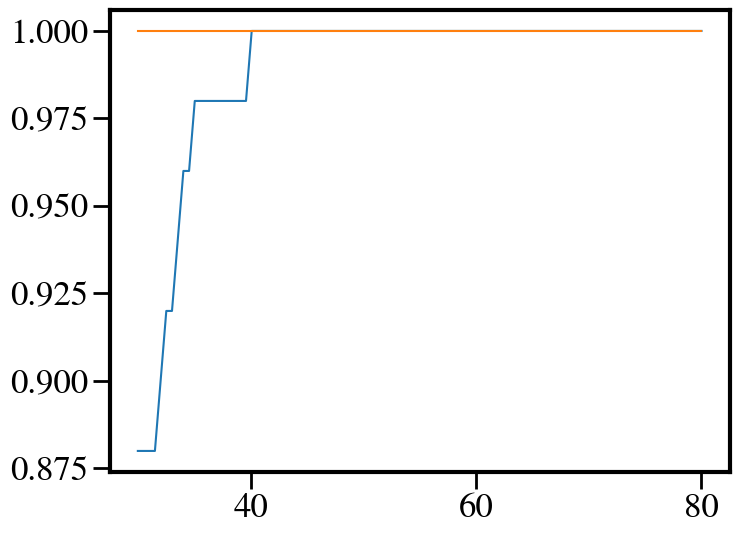

In [61]:
plt.plot(x,urma_gefsgrid_cdfs[:,100,500])
plt.plot(x, gefs_cdfs[:,100,500])

In [16]:
gefs_qm = np.empty((361,720))

for i in range(361):
    for j in range(720):
        percentile = scipy.stats.percentileofscore(gefs_temps[:,i,j], gefs_temps[:,i,j])
        gefs_qm[i,j] = np.median(np.percentile(urma_temps[:,i,j], percentile))

Text(0.5, 1.0, 'GEFS QM')

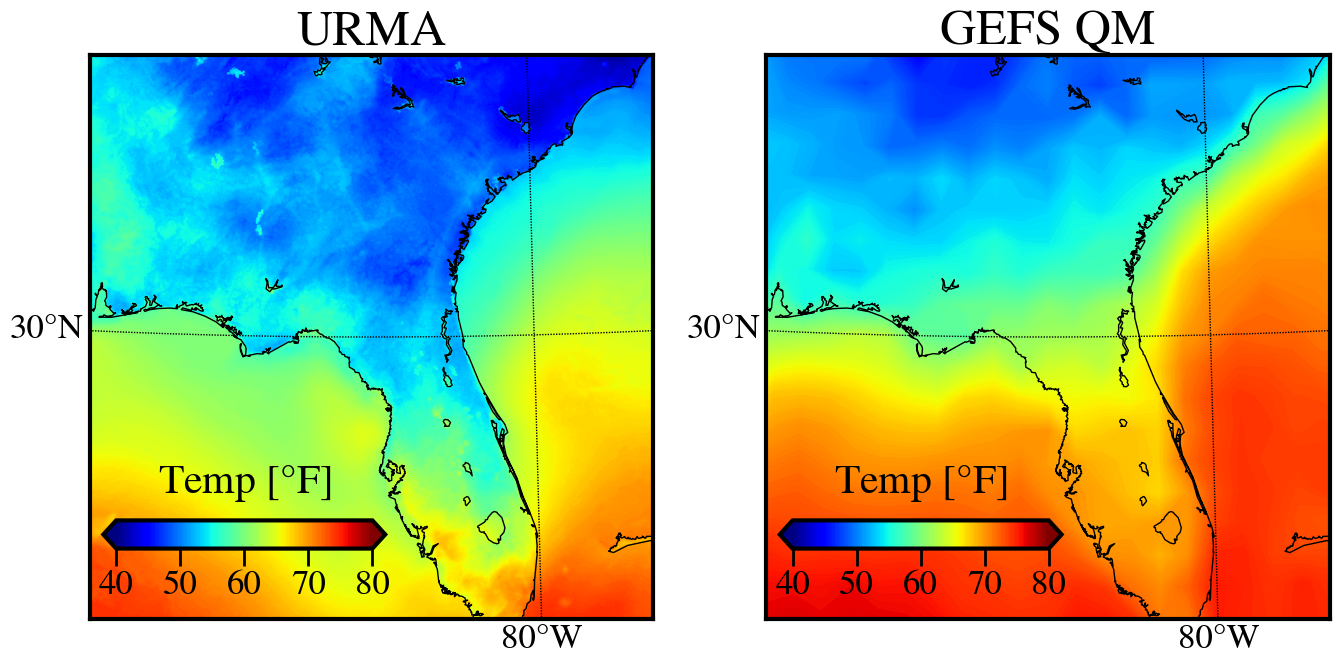

In [20]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

temp_range = np.linspace(40,80,200)

#urma first day
lats, lons = urma_data.latitude.data, urma_data.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
u_tmp = ((urma_data.TMP.data.compute())[0] * units.kelvin).to(units.fahrenheit)
cs = m.contourf(xx,yy,u_tmp,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_tmp = gefs_qm
cs = m.contourf(xx,yy,gefs_tmp,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA')
axes[1].set_title('GEFS QM')

## Coalescence

In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events. Coalecence attempts to conform these ensemble members to the ensemble mean using the feature align technique in order to alleviate these errors while maintaining the distribution of events predicted by the individual ensemble members. 